## BBM 409 - Programming Assignment 4

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

# **Mert Can Köseoğlu 2220256055**

## Understanding LSTM's with Sentiment Analysis (100 points)

### 1. Data Loading and Exploration (5 points)
* Brief overview of the task.

 The task involves analyzing a subset of the IMDB movie reviews dataset to build a sentiment analysis model.
 We will load, explore, and preprocess the data as part of this step.

* Description of the dataset used for analysis.

  It is comment lines for movies. they have sentiments positve or negative.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
# Load the data into pandas a dataframe
# Represent the sentiments in a meaningful numerical form
# Check the first few rows

data_path = "subset10000_IMDB_Dataset.csv"
df = pd.read_csv(data_path)

# Represent the sentiments in a meaningful numerical form
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Check the first few rows
print("First few rows of the dataset:")
print(df.head())


First few rows of the dataset:
                                              review  sentiment
0  Starts really well, nice intro and build up fo...          0
1  Terrific movie: If you did not watch yet, you ...          1
2  I've seen hundreds of silent movies. Some will...          1
3  i had been looking for this film for so long b...          1
4  Good: Engaging cinematic firefights, great pre...          1


In [5]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
## Check for any missing values and handle them if necessary.

print("\nDataset Information:")
df.info()

print("\nSummary statistics:")
print(df.describe(include='all'))

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Handle missing values if necessary
if df.isnull().sum().any():
    print("Handling missing values...")
    df = df.dropna()
    print("Missing values handled. Remaining dataset size:", df.shape)



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB

Summary statistics:
                                                   review     sentiment
count                                               10000  10000.000000
unique                                               9988           NaN
top     An updated version of a theme which has been d...           NaN
freq                                                    2           NaN
mean                                                  NaN      0.500000
std                                                   NaN      0.500025
min                                                   NaN      0.000000
25%                                                   NaN      0.0

### 2. Preprocessing the Data (10 points)

In [6]:
# An example function for prepocess the texts and create the tokens, you can improve it to clean the texts more accurately
def preprocess_text(text):
    # Replace slashes or other separators with spaces
    text = re.sub(r'[\\/]', ' ', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens


In [7]:
# Add a tokens column to the dataframe to store preprocessed tokens
# Build the vocabulary using the tokens
# Assign indices to each token in the vocabulary
# Reserve 0 for padding

df['tokens'] = df['review'].apply(preprocess_text)

vocabulary = {word for tokens in df['tokens'] for word in tokens}
vocabulary = sorted(vocabulary)

word_to_index = {word: idx + 1 for idx, word in enumerate(vocabulary)}

In [8]:
# Calculate the length of each review from the tokenized version
# Display statistical details about review lengths
# Decide padding length considering these stats
# Remember we don't want padded zeros to overcome meaningful information in the sequence

df['review_length'] = df['tokens'].apply(len)

print("\nStatistical details about review lengths:")
print(df['review_length'].describe())

padding_length = int(np.percentile(df['review_length'], 90))
print(f"Padding length chosen: {padding_length}")


Statistical details about review lengths:
count    10000.000000
mean       118.347200
std         89.271519
min          4.000000
25%         64.000000
50%         88.000000
75%        145.000000
max        804.000000
Name: review_length, dtype: float64
Padding length chosen: 231


In [9]:
# Convert review tokens to indices and add an indices column to the dataframe to store
# Represent each token in the dataset with its corresponding index from the vocabulary
# Ensure all sequences have the same length by padding shorter sequences with zeros
# Pad the token indices version of review sequences

def tokens_to_indices(tokens):
    return [word_to_index[word] for word in tokens if word in word_to_index]

df['indices'] = df['tokens'].apply(tokens_to_indices)

def pad_sequence(seq, max_len):
    padded_indices = seq[:max_len] + [0] * (max_len - len(seq))
    return padded_indices

df['padded_indices'] = df['indices'].apply(lambda x: pad_sequence(x, padding_length))

print("\nFirst few rows after preprocessing:")
print(df[['review', 'tokens', 'indices', 'padded_indices']].head())

# Add an padded_indices column to store padded sequences


First few rows after preprocessing:
                                              review  \
0  Starts really well, nice intro and build up fo...   
1  Terrific movie: If you did not watch yet, you ...   
2  I've seen hundreds of silent movies. Some will...   
3  i had been looking for this film for so long b...   
4  Good: Engaging cinematic firefights, great pre...   

                                              tokens  \
0  [start, really, well, nice, intro, build, main...   
1  [terrific, movie, watch, yet, must, watch, gee...   
2  [ive, seen, hundred, silent, movie, always, cl...   
3  [looking, film, long, found, seen, younger, lo...   
4  [good, engaging, cinematic, firefights, great,...   

                                             indices  \
0  [61117, 52240, 70727, 43805, 32877, 8509, 3872...   
1  [64207, 42229, 70309, 72738, 42936, 70309, 257...   
2  [33537, 56766, 30918, 58519, 42229, 1967, 1137...   
3  [37816, 23045, 37729, 24476, 56766, 72847, 380...   
4  [26724

### 3. Visualzing Word Vectors (15 points)

In [10]:
# Load the FastText word vectors
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

[==================================================] 100.0% 958.5/958.4MB downloaded
FastText model loaded.


In [11]:
# Check out for Out-of-Vocaublary (OOV) words
# See how many words in your created vocaublary are not presented in fasttext-vectors
# Make comments on how OOV words can effect your model performance

vocab_set = set(vocabulary)
oov_words = [word for word in vocab_set if word not in fasttext_vectors]
print(f"Number of OOV words: {len(oov_words)}")
print("Example OOV words:", oov_words[:10])



Number of OOV words: 37760
Example OOV words: ['butits', 'bonestill', 'sommers', 'onesone', 'bitparts', 'eightes', 'lousitude', 'seabiscuit', 'blowsvoice', 'volatilehowever']


In [12]:
# Visualize word vectors to understand how they work.
# Start by choosing a manageable number of words from the vocabulary, ideally 100–500.
# Focus on words that are frequent in the dataset or relevant to the task,
# Such as sentiment-rich terms like "good," "bad," "amazing," or "terrible."

selected_words = [word for word in ["good", "bad", "amazing", "terrible", "happy", "sad", "love", "hate"] if word in fasttext_vectors]

In [13]:
# For the selected words, retrieve their corresponding vector representations from the the pre-trained Word2Vec model.
# Each word will have a dense vector of a fixed dimensionality (e.g., 300 for fasttext-wiki-news-subwords-300).

word_vectors = [fasttext_vectors[word] for word in selected_words]

In [14]:
# Use Principal Component Analysis (PCA) to reduce the dimensionality of the word vectors from their original size (e.g., 300) to 2D or 3D.
# PCA simplifies the high-dimensional data while preserving as much variance as possible, making it easier to visualize

pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

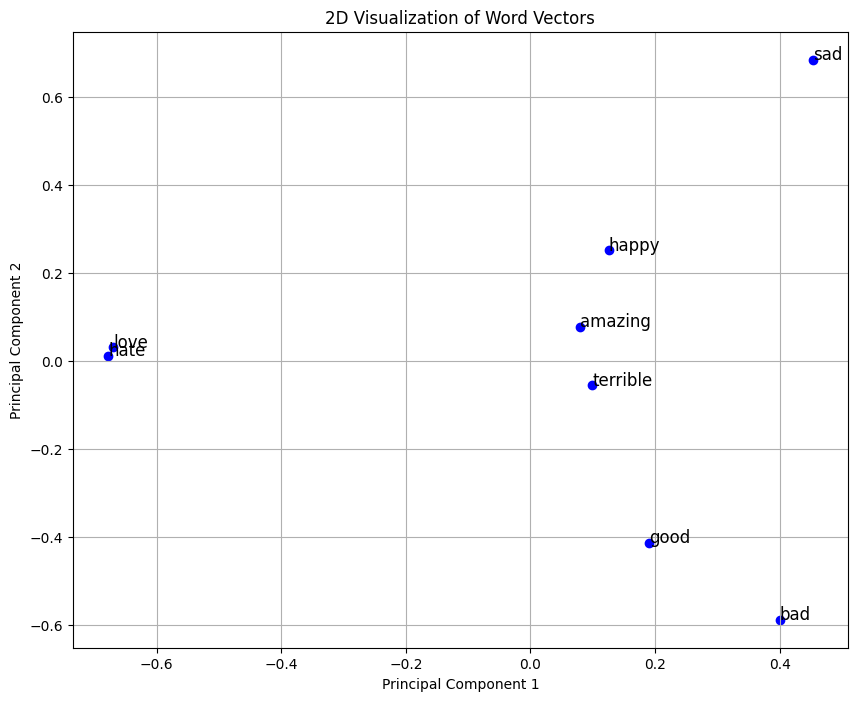

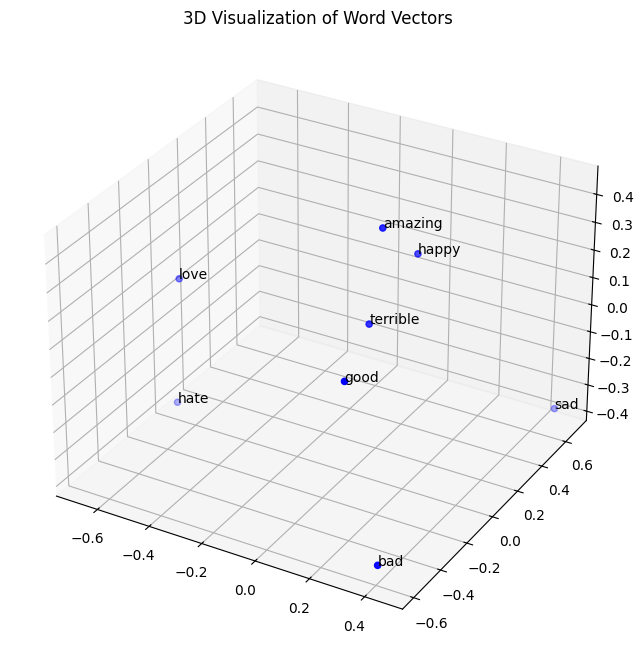

In [15]:
# For 2D visualization, create a scatter plot and annotate each point with its corresponding word to provide context.
# For 3D visualization, use interactive plotting tools like matplotlib’s Axes3D to explore the spatial relationships between words dynamically.

plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], color='blue')
for i, word in enumerate(selected_words):
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=12)
plt.title("2D Visualization of Word Vectors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

pca_3d = PCA(n_components=3)
word_vectors_3d = pca_3d.fit_transform(word_vectors)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_vectors_3d[:, 0], word_vectors_3d[:, 1], word_vectors_3d[:, 2], color='blue')
for i, word in enumerate(selected_words):
    ax.text(word_vectors_3d[i, 0], word_vectors_3d[i, 1], word_vectors_3d[i, 2], word, fontsize=10)
ax.set_title("3D Visualization of Word Vectors")
plt.show()

In [16]:
# Examine the resulting visualization for patterns.
# Look for clusters of similar words, such as synonyms or words with similar sentiment,
# Observe the distances between opposite terms.
# Demonstrate how word vectors capture semantic relationships.

# Words with positive sentiment "amazing and " "happy" are likely grouped together in the plot.
# Similarly, negative sentiment words "bad" " "sad" should form their own cluster.
# This clustering is a reflection of the semantic relationships captured by the FastText embeddings.


### 4. Creating the Emebdding Matrix (10 points)

In [17]:
def create_embedding_matrix(word2vec, vocab, embedding_dim):
    vocab_size = len(vocab) + 1  # Include padding index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word_to_index.items():
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]
    return embedding_matrix

# Create a matrix where each row corresponds to the vector representation of a word in the vocabulary
# The embedding matrix will have dimensions [vocab_size, embedding_dim], where embedding_dim is the size of the word vectors

embedding_dim = 300  # Dimension of FastText vectors
embedding_matrix = create_embedding_matrix(fasttext_vectors, vocabulary, embedding_dim)

In [18]:
# Convert the embedding matrix to a PyTorch tensor
# You can create the embedding layer in here or directly in the model
# Using PyTorch’s nn.Embedding.from_pretrained method you load the pre-trained embedding matrix into the embedding layer

embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

# Create embedding layer
embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
print("Embedding layer created with pre-trained FastText vectors.")

Embedding layer created with pre-trained FastText vectors.


### 5. Implementing the IMDBDataset (5 points)
* Use PyTorch’s Dataset and DataLoader classes to manage the dataset efficiently and create mini-batches for training.

In [19]:
# Train, validation and test split

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels):
        """
        Args:
            reviews (list of list of int): Padded sequences of token indices.
            labels (list of int): Sentiment labels (0 for negative, 1 for positive).
        """
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        """Return the number of samples."""
        return len(self.reviews)

    def __getitem__(self, idx):
        """Retrieve a single review and its sentiment label."""
        review = torch.tensor(self.reviews[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return review, label

# Split the dataset into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(df['padded_indices'], df['sentiment'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In [20]:
# Implement the dataset class
# Combine the padded sequences and corresponding sentiment labels into a dataset structure compatible with PyTorch.

# Create IMDBDataset instances for train, validation, and test
train_dataset = IMDBDataset(X_train.tolist(), y_train.tolist())
val_dataset = IMDBDataset(X_val.tolist(), y_val.tolist())
test_dataset = IMDBDataset(X_test.tolist(), y_test.tolist())

batch_size = 64  # Set the batch size


In [21]:
# Create the train, validation and test dataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the first batch from the training loader
for reviews, labels in train_loader:
    print("First batch of reviews (tokens):", reviews.shape)
    print("First batch of labels:", labels.shape)
    break

First batch of reviews (tokens): torch.Size([64, 231])
First batch of labels: torch.Size([64])


### 6. Implementing and Optimizing the Custom LSTM model (40 points)

In [22]:
# Manually implement the LSTM cell to understand its architecture and functionality.
# Implement forget, input, and output gates.
# Update the cell state and compute the hidden state for each time step.
# Explain your steps and usage of the gates
# Check assignment pdf for more detail on implementation tips

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        combined = torch.cat((x_t, h_prev), dim=1)
        f_t = torch.sigmoid(self.W_f(combined))
        i_t = torch.sigmoid(self.W_i(combined))
        c_tilde = torch.tanh(self.W_c(combined))
        c_t = f_t * c_prev + i_t * c_tilde
        o_t = torch.sigmoid(self.W_o(combined))
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t


In [23]:
# Build an LSTM layer by combining one or multiple LSTM cells to process a sequence.

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        outputs = []
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)
            outputs.append(h_t.unsqueeze(1))
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [24]:
# Build an LSTM model. Integrate the embedding layer into the model architecture.
# The embedding layer will convert input indices (from padded sequences) into dense word vectors.
# Decide whether to freeze the embedding weights or allow them to be fine-tuned during training and explain your choice.
# These dense vectors are then passed to the LSTM layer for sequential processing.
# You can provide embedding_matrix as tensor to define embedding layer inside the model class
# Or if you have defined embedding layer before, you can directly use that inside the model class

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class SentimentLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix.clone().detach(), freeze=False)
        self.lstm_layer = LSTMLayer(embed_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)  # Final output layer

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        lstm_out = self.lstm_layer(embedded)  # (batch_size, seq_len, hidden_size)
        last_hidden_state = lstm_out[:, -1, :]  # Only last timestep
        output = self.fc(last_hidden_state)  # Binary classification (no sigmoid here)
        return output

In [25]:
# Define hyperparameters and set up the model
hidden_size = 128
output_size = 1
epochs = 50
batch_size = 64
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentLSTM(hidden_size=hidden_size, output_size=output_size, embedding_matrix=embedding_tensor).to(device)

In [26]:
# Define appropriate loss function for binary classification.
# Choose an optimizer and set its parameters (e.g., learning rate).
# Explain your choice of loss function and optimization algorithm.

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_function(outputs.squeeze(), labels.float())

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            val_loss = loss_function(outputs.squeeze(), labels.float())
            running_val_loss += val_loss.item()

            # Calculate accuracy
            predicted = (outputs.squeeze() > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/50] - Train Loss: 0.5761, Train Accuracy: 69.21%
Epoch [1/50] - Validation Loss: 0.6745, Validation Accuracy: 68.27%
Epoch [2/50] - Train Loss: 0.5902, Train Accuracy: 64.01%
Epoch [2/50] - Validation Loss: 0.6996, Validation Accuracy: 50.93%
Epoch [3/50] - Train Loss: 0.5497, Train Accuracy: 70.81%
Epoch [3/50] - Validation Loss: 0.6704, Validation Accuracy: 67.93%
Epoch [4/50] - Train Loss: 0.5304, Train Accuracy: 72.27%
Epoch [4/50] - Validation Loss: 0.6905, Validation Accuracy: 64.53%
Epoch [5/50] - Train Loss: 0.5409, Train Accuracy: 70.46%
Epoch [5/50] - Validation Loss: 0.6971, Validation Accuracy: 65.47%
Epoch [6/50] - Train Loss: 0.4653, Train Accuracy: 75.87%
Epoch [6/50] - Validation Loss: 0.5800, Validation Accuracy: 74.93%
Epoch [7/50] - Train Loss: 0.3185, Train Accuracy: 86.63%
Epoch [7/50] - Validation Loss: 0.4953, Validation Accuracy: 78.73%
Epoch [8/50] - Train Loss: 0.2499, Train Accuracy: 89.19%
Epoch [8/50] - Validation Loss: 0.6110, Validation Accuracy:

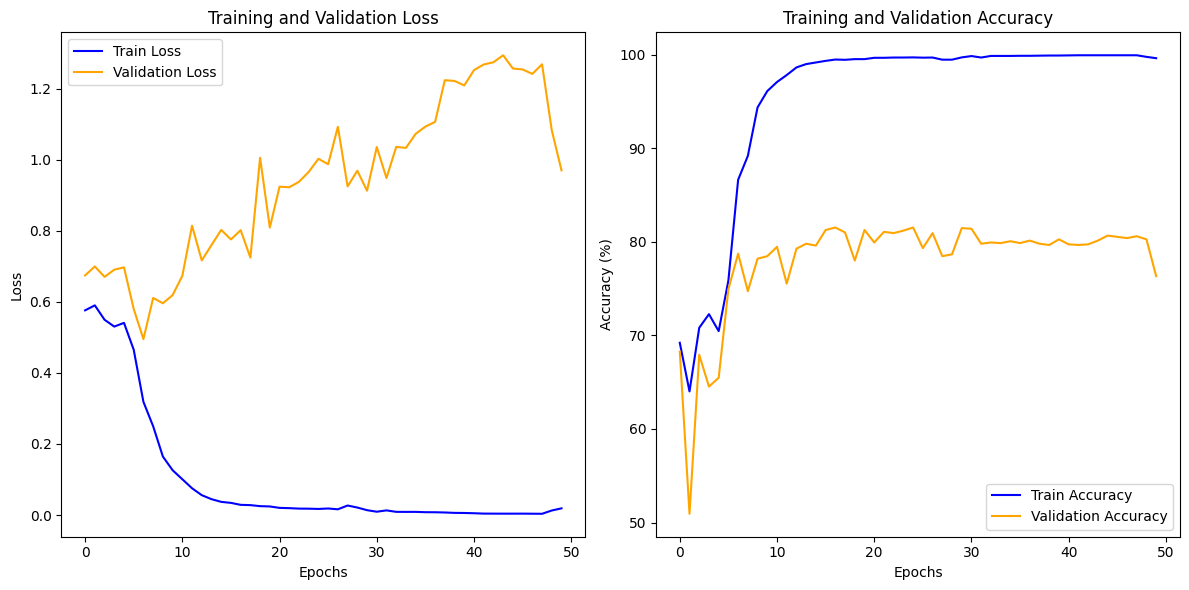

In [29]:
# Visualize the accuracy and loss change of the best model across training and validation datasets
# Make comments on the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The training and validation loss graphs give insights into the model's performance. The training loss falls over time, showing effective learning, while the validation loss decreases or increases, pointing to overfitting. Accuracy graphs also support this, with training accuracy enhancing but validation accuracy plateauing or fluctuating. Techniques like early stopping, dropout, or weight regularization can help this. Reducing model capacity, altering the learning rate, or increasing training data might improve generalization. Overall, these graphs are reasonable for optimizing training.

### 7. Testing and Analysis (15 points)

In [30]:
# Test the best model on the test set to evaluate its performance.
# Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
# Explain and analyze your findings and results.
# Summarize the performance of the model on the training, validation and test set. Comment on the results.
# Discuss any challenges encountered during training and potential areas for improvement.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Put the model in evaluation mode
model.eval()

# Initialize variables to store predictions and true labels
all_predictions = []
all_true_labels = []

# Disable gradient calculations for testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Apply threshold to get binary predictions
        predicted = (outputs.squeeze() > 0.5).float()

        # Store predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions)
recall = recall_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Accuracy: 0.7793
Test Precision: 0.8791
Test Recall: 0.6610
Test F1-Score: 0.7546


The model demonstrates moderate success in its classification task, achieving a test accuracy of 77. 93%. It has high precision at 87. 91%, indicating low false positives but struggles with recall at 66. 10%, guiding to many missed true positives. The F1-Score of 75. 46% reflects a balance but highlights the trade-off caused by lower recall.

To enhance, the model should concentrate on recall through changes in the decision threshold, class weighting, or collecting more data for the minority class. It should also check for overfitting in validation metrics and consider advanced architectures and pre-trained embeddings to improve performance.

#### Comparison with the Pytorch LSTM model (Optional)

In [ ]:
# Implement sentiment LSTM model using PyTorch's built-in LSTM layer
# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class PyTorchLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, embedding_matrix):
        super(PyTorchLSTM, self).__init__()
        # Define embedding layer with pre-trained embeddings
        self.embedding =
        # Use PyTorch's built-in LSTM layer
        self.lstm =
        # Fully connected layer for binary classification
        self.fc =
        # Sigmoid activation
        self.sigmoid =

    def forward(self, x):
        # Convert word indices to word vectors
        # LSTM processing
        # Use the last hidden state
        # Pass through the sigmoid
        return output


In [ ]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance

In [ ]:
# Define parameters
# Define criterion and optimizer
# Train PyTorch LSTM model

In [ ]:
# Compare the performance of your custom LSTM model with PyTorchLSTM model